/home/akhil/Desktop/mobileone/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda

--- Loading Dataset ---
Dataset loaded successfully
Classes found (7): ['actinic_keratoses', 'basal_cell_carcinoma', 'benign_keratosis-like_lesions', 'dermatofibroma', 'melanocytic_Nevi', 'melanoma', 'vascular_lesions']
Class to index mapping: {'actinic_keratoses': 0, 'basal_cell_carcinoma': 1, 'benign_keratosis-like_lesions': 2, 'dermatofibroma': 3, 'melanocytic_Nevi': 4, 'melanoma': 5, 'vascular_lesions': 6}

--- Creating Datasets ---
Train samples: 9577
Validation samples: 2492
Test samples: 1285

--- Computing Class Weights ---
Training Class Distribution: {'actinic_keratoses': 315, 'basal_cell_carcinoma': 487, 'benign_keratosis-like_lesions': 1048, 'dermatofibroma': 110, 'melanocytic_Nevi': 6405, 'melanoma': 1076, 'vascular_lesions': 136}
Class weights (dampened): [2.         1.67610508 1.14257596 2.         0.5        1.12761174
 2.        ]

Batch sizes - Train: 8, Val/Test: 4
Gradient Accumulation: 2 steps (Effective batch size: 16)
Gradient Clipping: 5.0

-

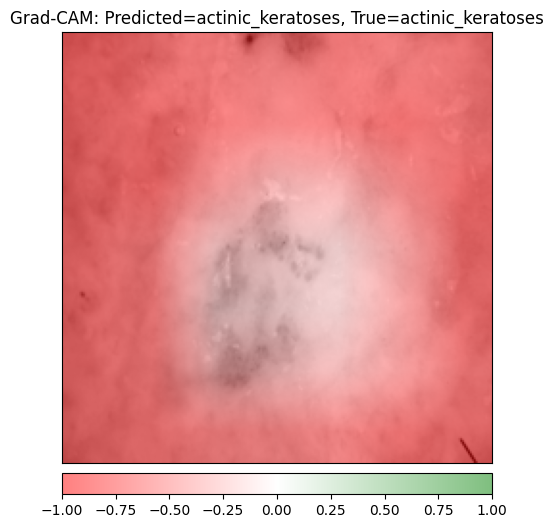

Grad-CAM visualization saved as 'grad_cam_resnext50_32x4d_a1h_in1k.png'

SCRIPT COMPLETE

Generated files:
  • best_resnext50_32x4d_a1h_in1k_model.pth
  • training_curves_resnext50_32x4d_a1h_in1k.png
  • lr_schedule_resnext50_32x4d_a1h_in1k.png
  • confusion_matrix_resnext50_32x4d_a1h_in1k.png
  • grad_cam_resnext50_32x4d_a1h_in1k.png


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from timm.models import create_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import load_dataset
from captum.attr import LayerGradCam
from captum.attr import visualization as viz
import os
from PIL import Image

# Setup device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using device: {device}")

# Define Focal Loss with stability improvements
class FocalLoss(nn.Module):
    """Focal Loss with stability improvements for class-imbalanced datasets."""
    def __init__(self, alpha=None, gamma=2.0, reduction='mean', epsilon=1e-7):
        super(FocalLoss, self).__init__()
        if alpha is not None:
            alpha = np.clip(alpha, 0.2, 2.0)
            self.register_buffer('alpha', torch.tensor(alpha, dtype=torch.float32))
        else:
            self.register_buffer('alpha', None)
        self.gamma = gamma
        self.reduction = reduction
        self.epsilon = epsilon

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss).clamp(min=self.epsilon, max=1.0 - self.epsilon)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Data Loading and Preprocessing
print("\n--- Loading Dataset ---")
try:
    ds = load_dataset("marmal88/skin_cancer")
    print("Dataset loaded successfully")
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# Create label mapping
classes = sorted(ds['train'].unique('dx'))
class_to_idx = {cls: i for i, cls in enumerate(classes)}
idx_to_class = {i: cls for cls, i in class_to_idx.items()}
num_classes = len(classes)
class_names = classes
print(f"Classes found ({num_classes}): {classes}")
print(f"Class to index mapping: {class_to_idx}")

# PyTorch Dataset Class
class SkinDataset(Dataset):
    def __init__(self, dataset_split, transform=None):
        self.dataset = dataset_split
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = class_to_idx[item['dx']]

        if self.transform:
            try:
                if not isinstance(image, Image.Image):
                    image_array = np.array(image)
                    if image_array.ndim == 2:
                        image_array = np.stack([image_array]*3, axis=-1)
                    elif image_array.ndim == 3 and image_array.shape[2] == 1:
                        image_array = np.concatenate([image_array]*3, axis=-1)
                    image = transforms.ToPILImage()(image_array)
                if np.any(np.isnan(image)) or np.any(np.isinf(image)):
                    raise ValueError(f"Invalid image at index {idx}: NaN or Inf values")
                image = self.transform(image)
            except Exception as e:
                print(f"Error transforming image at {idx}: {e}")
                raise e
        return image, torch.tensor(label, dtype=torch.long)

# Data augmentation
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
image_size = 224

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    normalize
])

val_test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    normalize
])

# Create datasets
print("\n--- Creating Datasets ---")
try:
    train_dataset = SkinDataset(ds['train'], transform=train_transform)
    val_dataset = SkinDataset(ds['validation'], transform=val_test_transform)
    test_dataset = SkinDataset(ds['test'], transform=val_test_transform)
    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
except KeyError as e:
    print(f"Error accessing dataset split: {e}")
    exit()

# Compute class weights
print("\n--- Computing Class Weights ---")
train_labels_list = [class_to_idx[label] for label in ds['train']['dx']]
unique_train_labels, train_counts = np.unique(train_labels_list, return_counts=True)
print("Training Class Distribution:", dict(zip([idx_to_class[i] for i in unique_train_labels], train_counts)))

class_weights_np = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_list),
    y=train_labels_list
)
# Modified class weights calculation - less aggressive clipping
class_weights_np = np.sqrt(class_weights_np)
class_weights_np = np.clip(class_weights_np, 0.5, 2.0)
print("Class weights (dampened):", class_weights_np)

# DataLoader configuration
train_batch_size = 8
val_test_batch_size = 4
ACCUMULATION_STEPS = 2
GRADIENT_CLIP_VALUE = 5.0

num_workers = 0 if os.name == 'nt' else max(0, os.cpu_count() // 2)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=use_cuda)
val_loader = DataLoader(val_dataset, batch_size=val_test_batch_size,
                        num_workers=num_workers, pin_memory=use_cuda)
test_loader = DataLoader(test_dataset, batch_size=val_test_batch_size,
                         num_workers=num_workers, pin_memory=use_cuda)

print(f"\nBatch sizes - Train: {train_batch_size}, Val/Test: {val_test_batch_size}")
print(f"Gradient Accumulation: {ACCUMULATION_STEPS} steps (Effective batch size: {train_batch_size * ACCUMULATION_STEPS})")
print(f"Gradient Clipping: {GRADIENT_CLIP_VALUE}")

# Model Configuration - ResNeXt50
print("\n--- Loading Model ---")
model_name = 'resnext50_32x4d.a1h_in1k'
try:
    model = create_model(model_name, pretrained=True, num_classes=num_classes)
    print(f"Model '{model_name}' loaded successfully")

    # ResNeXt-specific freezing strategy
    # ResNeXt architecture: conv1 (stem) -> bn1 -> layer1, layer2, layer3, layer4 -> fc
    # Freeze only the initial layers (stem and layer1) for transfer learning
    frozen_params = 0
    trainable_params = 0

    for name, param in model.named_parameters():
        if 'conv1' in name or 'bn1' in name or 'layer1' in name:
            param.requires_grad = False
            frozen_params += param.numel()
        else:
            param.requires_grad = True
            trainable_params += param.numel()

    model = model.to(device)

    total_params = frozen_params + trainable_params
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")
    print(f"Frozen parameters: {frozen_params:,} ({100*frozen_params/total_params:.1f}%)")

except Exception as e:
    print(f"Error creating model: {e}")
    import traceback
    traceback.print_exc()
    exit()

# Loss, optimizer, scheduler
print("\n--- Setting up Training Components ---")
criterion = FocalLoss(alpha=class_weights_np, gamma=2.0, reduction='mean').to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=5,
    T_mult=1,
    eta_min=1e-6
)

# Disable AMP for GTX 1650 stability
use_amp = False
scaler = torch.amp.GradScaler(device='cuda', enabled=use_amp)
print(f"Loss: Focal Loss (gamma={2.0}, alpha=class_weights)")
print(f"Optimizer: AdamW (lr=1e-4, weight_decay=1e-4)")
print(f"Scheduler: CosineAnnealingWarmRestarts (T_0=5)")
print(f"Mixed Precision (AMP): {use_amp}")

# Training Functions
def train_epoch(model, loader, criterion, optimizer, scaler, device, accumulation_steps,
                use_amp, epoch, warmup_epochs=3):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    nan_skipped = 0

    # Learning rate warmup for first few epochs
    if epoch < warmup_epochs:
        warmup_factor = (epoch + 1) / warmup_epochs
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * warmup_factor

    optimizer.zero_grad()

    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)

        skip_batch = False

        with torch.amp.autocast(device_type=device.type, enabled=use_amp):
            outputs = model(images)

            # Check for invalid outputs
            if torch.isnan(outputs).any() or torch.isinf(outputs).any():
                print(f"Warning: Invalid outputs at batch {i}. Skipping batch.")
                skip_batch = True

            if not skip_batch:
                loss = criterion(outputs, labels)

                # Check for invalid loss
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"Warning: Invalid loss at batch {i}. Skipping batch.")
                    skip_batch = True
                else:
                    loss = loss / accumulation_steps

        if skip_batch:
            optimizer.zero_grad()
            continue

        # Backward pass
        scaler.scale(loss).backward()

        # Gradient accumulation - update weights every N steps
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(loader):
            if use_amp:
                scaler.unscale_(optimizer)

            # Check for invalid gradients
            found_invalid = False
            max_grad_norm = 0.0
            for param in model.parameters():
                if param.grad is not None:
                    grad_norm = param.grad.norm().item()
                    max_grad_norm = max(max_grad_norm, grad_norm)
                    if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                        found_invalid = True
                        break

            if found_invalid or max_grad_norm > 500:
                nan_skipped += 1
                print(f"Warning: Invalid gradients at batch {i} (max norm: {max_grad_norm:.2f}). Skipping update.")
                optimizer.zero_grad()
                if use_amp:
                    scaler.update()
            else:
                # Clip gradients to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VALUE)

                if use_amp:
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()

                optimizer.zero_grad()

        # Accumulate metrics
        if not skip_batch:
            running_loss += (loss.item() * accumulation_steps) * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Restore learning rate after warmup
    if epoch < warmup_epochs:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] / warmup_factor

    if nan_skipped > 0:
        print(f"Total batches skipped due to invalid gradients: {nan_skipped}")

    epoch_loss = running_loss / len(loader.dataset) if len(loader.dataset) > 0 else 0
    epoch_acc = correct / total if total > 0 else 0
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device, use_amp):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            with torch.amp.autocast(device_type=device.type, enabled=use_amp):
                outputs = model(images)

                # Check for invalid outputs
                if torch.isnan(outputs).any() or torch.isinf(outputs).any():
                    print("Warning: Invalid outputs during validation.")
                    return float('nan'), 0.0

                loss = criterion(outputs, labels)

                # Check for invalid loss
                if torch.isnan(loss) or torch.isinf(loss):
                    print("Warning: Invalid loss during validation.")
                    return float('nan'), 0.0

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = val_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training Loop
num_epochs = 65
best_val_loss = float('inf')
patience = 5
early_stop_counter = 0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'lr': []}
model_save_path = f'best_{model_name.replace(".", "_")}_model.pth'

print("\n" + "="*70)
print("TRAINING START")
print("="*70)
try:
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler,
                                           device, ACCUMULATION_STEPS, use_amp, epoch)
        val_loss, val_acc = validate(model, val_loader, criterion, device, use_amp)

        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step()

        # Check for training collapse
        if np.isnan(train_loss) or np.isinf(train_loss) or np.isnan(val_loss) or np.isinf(val_loss):
            print(f"\nEpoch {epoch+1}/{num_epochs}: Training collapsed (NaN/Inf detected). Stopping.")
            break

        # Record history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        # Print epoch results
        print(f"\nEpoch {epoch+1}/{num_epochs}:")
        print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(f"  LR: {current_lr:.6f}")

        # Save best model
        if not np.isnan(val_loss) and val_loss < best_val_loss:
            try:
                torch.save(model.state_dict(), model_save_path)
                best_val_loss = val_loss
                early_stop_counter = 0
                print(f"  ✓ Best model saved (val_loss: {best_val_loss:.4f})")
            except Exception as e:
                print(f"  ✗ Error saving model: {e}")
        else:
            early_stop_counter += 1
            print(f"  No improvement ({early_stop_counter}/{patience})")
            if early_stop_counter >= patience:
                print(f"\n Early stopping triggered after {patience} epochs without improvement.")
                break

except KeyboardInterrupt:
    print("\n" + "="*70)
    print("TRAINING INTERRUPTED BY USER")
    print("="*70)
except Exception as e:
    print("\n" + "="*70)
    print(f"TRAINING ERROR: {e}")
    print("="*70)
    import traceback
    traceback.print_exc()
finally:
    print("\n" + "="*70)
    print("TRAINING COMPLETE")
    print("="*70)

# Evaluation
if os.path.exists(model_save_path):
    print(f"\n--- Loading Best Model ---")
    print(f"Loading from: {model_save_path}")
    try:
        model.load_state_dict(torch.load(model_save_path, map_location=device))
        print("Model loaded successfully")

        print("\n--- Evaluating on Test Set ---")
        test_loss, test_acc = validate(model, test_loader, criterion, device, use_amp)
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")

        # Collect predictions
        print("\n--- Generating Predictions ---")
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                with torch.amp.autocast(device_type=device.type, enabled=use_amp):
                    outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        # Classification Report
        print("\n--- Classification Report ---")
        try:
            report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
            print(report)
        except Exception as e:
            print(f"Error generating classification report: {e}")

        # Confusion Matrix
        print("\n--- Generating Confusion Matrix ---")
        try:
            cm = confusion_matrix(y_true, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=class_names, yticklabels=class_names)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix - {model_name}')
            plt.tight_layout()
            cm_filename = f'confusion_matrix_{model_name.replace(".", "_")}.png'
            plt.savefig(cm_filename)
            plt.close()
            print(f"Confusion matrix saved as '{cm_filename}'")
        except Exception as e:
            print(f"Error plotting confusion matrix: {e}")

    except Exception as e:
        print(f"Error during evaluation: {e}")
        import traceback
        traceback.print_exc()
else:
    print("\n⚠ No saved model found. Skipping evaluation.")

# Training Curves
if history['train_loss']:
    print("\n--- Generating Training Curves ---")
    try:
        # Loss and Accuracy curves
        plt.figure(figsize=(15, 6))

        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
        plt.plot(history['val_loss'], label='Val Loss', linewidth=2)
        plt.title(f'Loss Curves - {model_name}', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], label='Train Acc', linewidth=2)
        plt.plot(history['val_acc'], label='Val Acc', linewidth=2)
        plt.title(f'Accuracy Curves - {model_name}', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        curves_filename = f'training_curves_{model_name.replace(".", "_")}.png'
        plt.savefig(curves_filename, dpi=150)
        plt.close()
        print(f"Training curves saved as '{curves_filename}'")

        # Learning rate schedule
        plt.figure(figsize=(7, 5))
        plt.plot(history['lr'], linewidth=2, color='darkorange')
        plt.title(f'Learning Rate Schedule - {model_name}', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Learning Rate', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        lr_filename = f'lr_schedule_{model_name.replace(".", "_")}.png'
        plt.savefig(lr_filename, dpi=150)
        plt.close()
        print(f"LR schedule saved as '{lr_filename}'")

    except Exception as e:
        print(f"Error plotting training curves: {e}")

# Grad-CAM Visualization
if os.path.exists(model_save_path) and 'test_loader' in locals():
    print("\n--- Generating Grad-CAM Visualization ---")

    def visualize_grad_cam(model, loader, device, target_layer, idx_to_class, model_name_str, use_amp):
        """Generate and save Grad-CAM visualization for a test image."""
        model.eval()

        # Get a test image
        try:
            images, labels = next(iter(loader))
        except StopIteration:
            print("Empty test loader. Skipping Grad-CAM.")
            return

        img_tensor = images[0:1].to(device)
        true_label_idx = labels[0].item()
        true_label_name = idx_to_class.get(true_label_idx, "Unknown")

        # Initialize Grad-CAM
        try:
            layer_gc = LayerGradCam(model, target_layer)
        except Exception as e:
            print(f"Error initializing Grad-CAM: {e}")
            return

        # Get prediction
        try:
            with torch.no_grad():
                with torch.amp.autocast(device_type=device.type, enabled=use_amp):
                    output = model(img_tensor)
                pred_label_idx = torch.argmax(output, dim=1).item()
                pred_label_name = idx_to_class.get(pred_label_idx, "Unknown")
                print(f"Predicted: {pred_label_name}, True: {true_label_name}")
        except Exception as e:
            print(f"Error during prediction: {e}")
            return

        # Compute attribution
        try:
            with torch.amp.autocast(device_type=device.type, enabled=use_amp):
                attribution = layer_gc.attribute(img_tensor, target=pred_label_idx)
        except Exception as e:
            print(f"Error computing attributions: {e}")
            return

        # Prepare original image for visualization
        try:
            original_image = np.transpose(img_tensor.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            original_image = (original_image * std) + mean
            original_image = np.clip(original_image, 0, 1)
        except Exception as e:
            print(f"Error processing image: {e}")
            return

        # Visualize and save
        grad_cam_filename = f'grad_cam_{model_name_str}.png'
        try:
            attribution_upsampled = F.interpolate(attribution, size=(image_size, image_size),
                                                 mode='bilinear', align_corners=False)

            fig, _ = viz.visualize_image_attr(
                np.transpose(attribution_upsampled.squeeze(0).cpu().detach().numpy(), (1, 2, 0)),
                original_image,
                method="blended_heat_map",
                sign="all",
                show_colorbar=True,
                title=f"Grad-CAM: Predicted={pred_label_name}, True={true_label_name}"
            )
            fig.savefig(grad_cam_filename, dpi=150, bbox_inches='tight')
            print(f"Grad-CAM visualization saved as '{grad_cam_filename}'")
            plt.close(fig)
        except Exception as e:
            print(f"Error visualizing Grad-CAM: {e}")

    try:
        # ResNeXt50 architecture-specific target layer selection
        # ResNeXt structure: conv1 -> bn1 -> layer1, layer2, layer3, layer4 -> fc
        # Each layer contains Bottleneck blocks with: conv1 -> conv2 -> conv3
        # We target the last conv layer (conv3) of the final block in layer4

        target_layer = None

        if hasattr(model, 'layer4'):
            # Standard ResNet/ResNeXt naming convention
            target_layer = model.layer4[-1].conv3
            print(f"Target layer: layer4[-1].conv3")
        elif hasattr(model, 'stages'):
            # Alternative naming (some timm models)
            target_layer = model.stages[-1][-1].conv3
            print(f"Target layer: stages[-1][-1].conv3")
        else:
            # Fallback: search for the layer manually
            print("Searching for appropriate target layer...")
            for name, module in model.named_modules():
                if 'layer4' in name and 'conv3' in name:
                    target_layer = module
                    print(f"Found target layer: {name}")
                    break

        if target_layer is None:
            print("Could not find appropriate target layer. Available layers:")
            for name, _ in model.named_modules():
                if any(x in name for x in ['conv', 'layer']):
                    print(f"  {name}")
            raise AttributeError("Could not identify Grad-CAM target layer")

        # Generate Grad-CAM
        visualize_grad_cam(model, test_loader, device, target_layer,
                          idx_to_class, model_name.replace('.', '_'), use_amp)

    except AttributeError as e:
        print(f"Error finding Grad-CAM target layer: {e}")
    except Exception as e:
        print(f"Error during Grad-CAM generation: {e}")
        import traceback
        traceback.print_exc()
else:
    print("\n⚠ Skipping Grad-CAM visualization (no model or test data available).")

print("\n" + "="*70)
print("SCRIPT COMPLETE")
print("="*70)
print("\nGenerated files:")
if os.path.exists(model_save_path):
    print(f"  • {model_save_path}")
if history['train_loss']:
    print(f"  • training_curves_{model_name.replace('.', '_')}.png")
    print(f"  • lr_schedule_{model_name.replace('.', '_')}.png")
    print(f"  • confusion_matrix_{model_name.replace('.', '_')}.png")
    print(f"  • grad_cam_{model_name.replace('.', '_')}.png")
print("="*70)

In [1]:
pip install timm

In [6]:
import timm

# ✅ Correct way: use wildcards for substring matching
all_efficientnet_models = timm.list_models(pretrained=True, filter='*efficientnet*')
print("EfficientNet models:", all_efficientnet_models)

EfficientNet models: ['efficientnet_b0.ra4_e3600_r224_in1k', 'efficientnet_b0.ra_in1k', 'efficientnet_b1.ft_in1k', 'efficientnet_b1.ra4_e3600_r240_in1k', 'efficientnet_b1_pruned.in1k', 'efficientnet_b2.ra_in1k', 'efficientnet_b2_pruned.in1k', 'efficientnet_b3.ra2_in1k', 'efficientnet_b3_pruned.in1k', 'efficientnet_b4.ra2_in1k', 'efficientnet_b5.sw_in12k', 'efficientnet_b5.sw_in12k_ft_in1k', 'efficientnet_el.ra_in1k', 'efficientnet_el_pruned.in1k', 'efficientnet_em.ra2_in1k', 'efficientnet_es.ra_in1k', 'efficientnet_es_pruned.in1k', 'efficientnet_lite0.ra_in1k', 'efficientnetv2_rw_m.agc_in1k', 'efficientnetv2_rw_s.ra2_in1k', 'efficientnetv2_rw_t.ra2_in1k', 'gc_efficientnetv2_rw_t.agc_in1k', 'test_efficientnet.r160_in1k', 'test_efficientnet_evos.r160_in1k', 'test_efficientnet_gn.r160_in1k', 'test_efficientnet_ln.r160_in1k', 'tf_efficientnet_b0.aa_in1k', 'tf_efficientnet_b0.ap_in1k', 'tf_efficientnet_b0.in1k', 'tf_efficientnet_b0.ns_jft_in1k', 'tf_efficientnet_b1.aa_in1k', 'tf_efficientne